In [2]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error

In [3]:
class ProcessingData:
    
    def __init__(self,filepath):
        with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            self.data = u.load()

    def fix_data(self, interval):
        """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
        converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
        don't have dt equal to interval.
        :param data:
        :param interval: float:minutes"""
        def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

        def h(x):
            if x == 1:
                return 1
            else:
                return 0

        def c(x):
            if x == 2:
                return 1
            else:
                return 0

        self.data["action"] = self.data["action"].map(f)
        self.data['action_heating'] = self.data["action"].map(h)
        self.data['action_cooling'] = self.data['action'].map(c)

        #print self.data.head()

        return self.data, self.data[self.data["dt"] == interval]
    
    def filter_data(self):
        self.data = self.data.drop(['t_next', 'dt', 'action', 'previous_action', 'action_duration', \
                                    'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        return self.data
    
    def drop_nan(self):
        self.data = self.data.dropna()
        return self.data


In [4]:
training = ProcessingData("../Data/avenal-animal-shelter_training_data.pkl")
training_data = training.fix_data(5)
training_data = training.filter_data()
training_data = training.drop_nan()
training_data.head()

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-04-18 23:16:42+00:00,69.483333,66.499700,0.0,0,0
2018-04-18 23:21:42+00:00,69.500000,66.499700,0.0,0,0
2018-04-18 23:26:42+00:00,69.500000,66.520546,0.0,0,0
2018-04-18 23:31:42+00:00,69.500000,66.583083,0.0,0,0
2018-04-18 23:36:42+00:00,69.400000,66.666466,0.0,0,0


In [5]:
testing = ProcessingData("../Data/avenal-animal-shelter_test_data.pkl")
testing_data = testing.fix_data(5)
testing_data = testing.filter_data()
testing_data = testing.drop_nan()
testing_data.head()

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-03-20 00:00:00+00:00,72.8,67.778613,0.0,0,0
2018-03-20 00:05:00+00:00,72.8,67.807436,0.0,0,0
2018-03-20 00:10:00+00:00,73.0,67.835998,0.0,0,0
2018-03-20 00:15:00+00:00,73.0,67.864038,0.0,0,0
2018-03-20 00:20:00+00:00,73.0,67.891817,0.0,0,0


In [6]:
def scaling(data):
    scaled = np.empty([data.shape[0], data.shape[1]])
    maxValues = []
    numSamples = data.shape[0]
    numFeatures = data.shape[1]
    dataValues = data.values
    dataValues = dataValues.astype('float32')
    for i in range(numFeatures):
        maxNum = max(dataValues[:,i])
        maxValues.append(maxNum)
        for j in range(numSamples):
            scaled[j,i] = dataValues[j,i]/maxNum
    return scaled, maxValues

In [7]:
train_scaled, maxValues = scaling(training_data)
print("Max Values:", maxValues)
print(train_scaled)

Max Values: [81.099998, 104.0, 1.0, 1.0, 1.0]
[[ 0.85676116  0.63942021  0.          0.          0.        ]
 [ 0.85696673  0.63942021  0.          0.          0.        ]
 [ 0.85696673  0.63962066  0.          0.          0.        ]
 ..., 
 [ 0.85080147  0.74038088  0.          0.          0.        ]
 [ 0.85573369  0.74038088  0.          0.          0.        ]
 [ 0.85819978  0.74038088  0.          0.          0.        ]]


In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
train_reframed = series_to_supervised(train_scaled, 1, 1)
train_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.856761,0.639420,0.0,0.0,0.0,0.856967,0.639420,0.0,0.0,0.0
2,0.856967,0.639420,0.0,0.0,0.0,0.856967,0.639621,0.0,0.0,0.0
3,0.856967,0.639621,0.0,0.0,0.0,0.856967,0.640222,0.0,0.0,0.0
4,0.856967,0.640222,0.0,0.0,0.0,0.855734,0.641024,0.0,0.0,0.0
5,0.855734,0.641024,0.0,0.0,0.0,0.856967,0.641625,0.0,0.0,0.0


In [10]:
train_reframed.drop(train_reframed.columns[-4:], axis=1, inplace=True)
train_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.856761,0.639420,0.0,0.0,0.0,0.856967
2,0.856967,0.639420,0.0,0.0,0.0,0.856967
3,0.856967,0.639621,0.0,0.0,0.0,0.856967
4,0.856967,0.640222,0.0,0.0,0.0,0.855734
5,0.855734,0.641024,0.0,0.0,0.0,0.856967


In [11]:
test_scaled, test_maxValues = scaling(testing_data)
test_reframed = series_to_supervised(test_scaled, 1, 1)
test_reframed.drop(test_reframed.columns[-4:], axis=1, inplace=True)
test_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.941785,0.747789,0.0,0.0,0.0,0.941785
2,0.941785,0.748107,0.0,0.0,0.0,0.944373
3,0.944373,0.748422,0.0,0.0,0.0,0.944373
4,0.944373,0.748731,0.0,0.0,0.0,0.944373
5,0.944373,0.749038,0.0,0.0,0.0,0.944373


In [12]:
# split into input and outputs
train = train_reframed.values
test = test_reframed.values
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [13]:
train_X

array([[ 0.85676116,  0.63942021,  0.        ,  0.        ,  0.        ],
       [ 0.85696673,  0.63942021,  0.        ,  0.        ,  0.        ],
       [ 0.85696673,  0.63962066,  0.        ,  0.        ,  0.        ],
       ..., 
       [ 0.84956849,  0.74038088,  0.66000003,  0.        ,  0.        ],
       [ 0.85080147,  0.74038088,  0.        ,  0.        ,  0.        ],
       [ 0.85573369,  0.74038088,  0.        ,  0.        ,  0.        ]])

In [14]:
def invert_scaling(data, maxNum):
    inv = np.array([])
    for i in data:
        inv = np.append(inv, i*maxNum)
    return inv

In [15]:
from sklearn.linear_model import LinearRegression

linearModel = LinearRegression().fit(train_X, train_y)
test_pred = linearModel.predict(test_X)
test_pred

array([ 0.94160204,  0.94160332,  0.9441699 , ...,  0.93607169,
        0.93607277,  0.93735546])

In [16]:
maxT_in = max(testing_data['t_in'])
maxT_in

77.299999999999997

In [17]:
test_y

array([ 0.94178528,  0.94437253,  0.94437253, ...,  0.93531692,
        0.93661058,  0.93790424])

In [18]:
inv_y = invert_scaling(test_y, maxT_in)
print(inv_y)

[ 72.80000183  72.99999694  72.99999694 ...,  72.29999794  72.39999779
  72.49999765]


In [19]:
testing_data.head()

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-03-20 00:00:00+00:00,72.8,67.778613,0.0,0,0
2018-03-20 00:05:00+00:00,72.8,67.807436,0.0,0,0
2018-03-20 00:10:00+00:00,73.0,67.835998,0.0,0,0
2018-03-20 00:15:00+00:00,73.0,67.864038,0.0,0,0
2018-03-20 00:20:00+00:00,73.0,67.891817,0.0,0,0


In [20]:
inv_pred = invert_scaling(test_pred, maxT_in)
print(inv_pred)

[ 72.78583794  72.78593637  72.98433361 ...,  72.35834146  72.35842478
  72.4575769 ]


In [21]:
rmse = sqrt(mean_squared_error(inv_y, inv_pred))
rmse

0.8632400249480561

In [22]:
test_X

array([[ 0.94178528,  0.74778891,  0.        ,  0.        ,  0.        ],
       [ 0.94178528,  0.7481069 ,  0.        ,  0.        ,  0.        ],
       [ 0.94437253,  0.74842209,  0.        ,  0.        ,  0.        ],
       ..., 
       [ 0.93531692,  0.96833682,  0.        ,  0.        ,  0.        ],
       [ 0.93531692,  0.968606  ,  0.        ,  0.        ,  0.        ],
       [ 0.93661058,  0.968606  ,  0.        ,  0.        ,  0.        ]])

In [53]:
def autoRegression(subtest_X, t, maxT_in):
    t = int(t/5)
    pred = []
    t_next = subtest_X[0].shift(-t).dropna()
    t_next = invert_scaling(t_next, maxT_in)
    for i in range(subtest_X.shape[0]):
        input_x = subtest_X.iloc[i]
        pred5 = linearModel.predict([input_x])
        j=1
        while j<t:
            input_x[0] = pred5[0]
            pred5 = linearModel.predict([input_x])
            j = j+1
        pred.append(pred5[0]*maxT_in)
    #print(pred)
    rmse = sqrt(mean_squared_error(t_next, pred[:-t]))
    return rmse

In [54]:
test_X = pd.DataFrame(test_X)
subtest_X = test_X.head(20)
autoRegression(test_X, 5, maxT_in)
#subtest_X[0]

0.8633895100097012

In [38]:
t_next = subtest_X[0].shift(-2).dropna()
invert_scaling(t_next, maxT_in)

array([ 72.93813585,  72.93851396,  72.93888865,  72.93852919,
        72.93670154,  72.93413989,  73.02903901,  73.02890457,
        73.02957917,  73.02952343,  73.02800692,  73.12240747,
        73.02435882,  73.12129581,  73.12243101,  73.12290209,
        73.12204496,  73.12052363])

In [46]:
testing_data.head(10)

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-03-20 00:00:00+00:00,72.8,67.778613,0.0,0,0
2018-03-20 00:05:00+00:00,72.8,67.807436,0.0,0,0
2018-03-20 00:10:00+00:00,73.0,67.835998,0.0,0,0
2018-03-20 00:15:00+00:00,73.0,67.864038,0.0,0,0
2018-03-20 00:20:00+00:00,73.0,67.891817,0.0,0,0
2018-03-20 00:25:00+00:00,73.0,67.865168,0.0,0,0
2018-03-20 00:30:00+00:00,73.0,67.729663,0.0,0,0
2018-03-20 00:35:00+00:00,73.0,67.539731,0.0,0,0
2018-03-20 00:40:00+00:00,73.1,67.409787,0.0,0,0


[0.8635388392763137, 0.8846882012733475, 0.8954244095670839, 0.9074433474840039, 0.927040951441978, 0.9682138790406709, 1.038082565538213, 1.155238491472955, 1.302822134461188, 1.485417009717252, 1.7217848665709938]


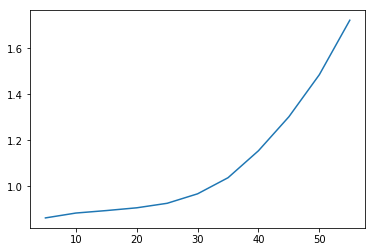

In [56]:
test_X = pd.DataFrame(test_X)
subtest_X = test_X.head(30)

time = []
rmse = []
for t in range(5,60,5):
    time.append(t)
    rmse.append(autoRegression(test_X, t, maxT_in))
print(rmse)
plt.plot(time, rmse)
plt.show()